<a href="https://colab.research.google.com/github/clementsiegrist/spot_detector/blob/main/Last_and_least.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install keras opencv-python tensorflow scikit-learn scikit-image numpy pillow matplotlib imutils

In [2]:
!git clone https://github.com/hmelo/nuclei_segmenter_counter

fatal: destination path 'nuclei_segmenter_counter' already exists and is not an empty directory.


In [3]:
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

# I Segmentation with Deep Learning

Create a simple Unet.
This architecture won a number of high level competitions like the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015 as well as the Cell Tracking Challenge at ISBI 2015 on transmitted light microscopy  (Phase contrast and DIC microscopy).

Credits to https://github.com/hmelo/nuclei_segmenter_counter for the pretrained model and cells counting function.

In [4]:
def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X & Y|)/ (|X or Y|)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f, -1) + K.sum(y_pred_f, -1) - intersection
    return (intersection + smooth) / (union + smooth)

def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[iou_coef])
    return model

Instantiate Unet and load weights

In [5]:
from keras.layers import *
from keras.models import Model

model = get_unet(176, 176, 3)
model.load_weights('/content/nuclei_segmenter_counter/unet_simple_model_150epochs_weights.h5')

Load image and reshape it.

Then, make predictions and plot the results of the segmentation.

We need to instantiate an other unet model for the third image 101878272(1).png as its shape is different from the two others.




In [21]:
# Open the third image 101878272(1).png and reshape it to fit it to the neural net.
img_ = Image.open('/content/101878272(1).png')
img_ = np.asarray(img_)
print(img_.shape)
img_ = img_[:,:, :3]
img_ = np.reshape(img_, newshape=(1, 419, 660, 3))
img_ = img_[:, :384, :640, :]
# Make prediction
model_bis = get_unet(640, 384, 3)
model_bis.load_weights('/content/nuclei_segmenter_counter/unet_simple_model_150epochs_weights.h5')
img_2 = model_bis.predict(img_)
img_2 = np.squeeze(img_2, axis=(0, 3))
img_ = np.squeeze(img_, axis=0)

(419, 660, 3)


Load image and reshape it.

Then, make predictions and plot the results of the segmentation.

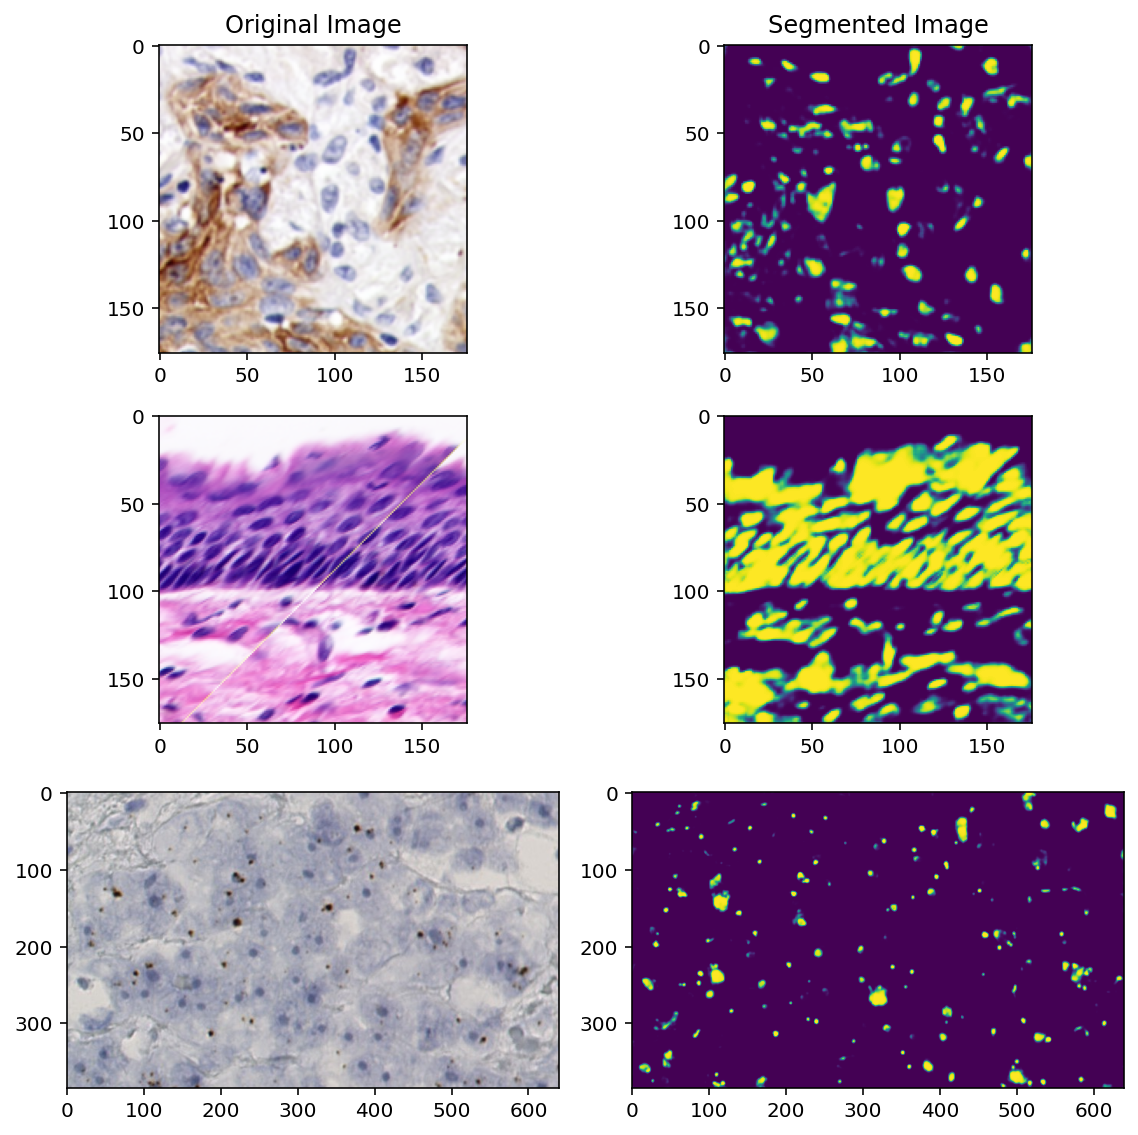

In [22]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Open the first image and reshape it to fit it to the neural net
img = Image.open('/content/hdAB.png')
img = np.asarray(img)
img = img[:,:, :3]
img = np.reshape(img, newshape=(1, 189, 189, 3))
img = img[:, :176, :176, :]
# Make prediction
img_1 = model.predict(img)
img_1 = np.squeeze(img_1, axis=(0, 3))
img = np.squeeze(img, axis=0)

# Open the second image and reshape it to fit it to the neural net
img_sec = Image.open('/content/he(1).png')
img_sec = np.asarray(img_sec)
img_sec = img_sec[:,:, :3]
img_sec = np.reshape(img_sec, newshape=(1, 189, 190, 3))
img_sec = img_sec[:, :176, :176, :]
# Make prediction
img_secbis = model.predict(img_sec)
img_secbis = np.squeeze(img_secbis, axis=(0, 3))
img_sec = np.squeeze(img_sec, axis=0)

# Plot the results
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
ax = axes.flatten()
ax[0].imshow(img)
ax[0].set_title("Original Image", fontsize=12)
ax[1].imshow(img_1)
ax[1].set_title("Segmented Image", fontsize=12)
ax[2].imshow(img_sec)
ax[3].imshow(img_secbis)
ax[4].imshow(img_)
ax[5].imshow(img_2)
fig.tight_layout()
plt.show()
#plt.imshow(img_1)
#plt.show()

The function count_cells() find the contours with cv2.findContours, draw them with cv2.drawcontours and plot them on the image given in the first argument.

In [7]:
def count_cells(pred_mask, t=65):
    
    img_mask=np.squeeze(pred_mask)
    plt.imsave('test.png', img_mask)

    image = Image.open('test.png').convert("L")
    img = np.asarray(image)
    img = img.copy()
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    (t, binary) = cv2.threshold(blur, t, 255, cv2.THRESH_BINARY)

    # find contours
    #(_, contours, _) = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # create all-black mask image
    mask = np.zeros(img.shape, dtype="uint8")

    # draw white rectangles for each object's bounding box
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 255, 255), -1)

    # draw contours over original image
    cv2.drawContours(img, contours, -1, (255, 100, 100), 1)

    fig1 = plt.figure(figsize=(8, 8))
    plt.subplot(121).set_title('Cells Counted')
    plt.imshow(img)
    plt.show()

    # print table of contours and sizes
    print("Found %d cells." % len(contours))
    for (i, c) in enumerate(contours):
        print("\tSize of cell %d: %d" % (i, len(c)))
    return

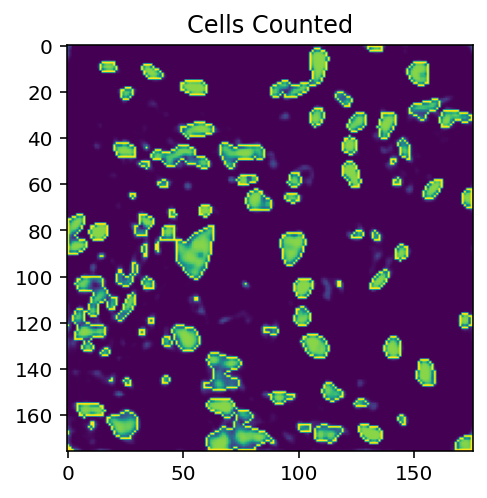

Found 82 cells.
	Size of cell 0: 3
	Size of cell 1: 7
	Size of cell 2: 2
	Size of cell 3: 14
	Size of cell 4: 17
	Size of cell 5: 5
	Size of cell 6: 6
	Size of cell 7: 7
	Size of cell 8: 22
	Size of cell 9: 14
	Size of cell 10: 6
	Size of cell 11: 57
	Size of cell 12: 13
	Size of cell 13: 19
	Size of cell 14: 7
	Size of cell 15: 3
	Size of cell 16: 7
	Size of cell 17: 12
	Size of cell 18: 34
	Size of cell 19: 7
	Size of cell 20: 12
	Size of cell 21: 22
	Size of cell 22: 4
	Size of cell 23: 8
	Size of cell 24: 27
	Size of cell 25: 1
	Size of cell 26: 4
	Size of cell 27: 10
	Size of cell 28: 11
	Size of cell 29: 4
	Size of cell 30: 16
	Size of cell 31: 1
	Size of cell 32: 4
	Size of cell 33: 12
	Size of cell 34: 9
	Size of cell 35: 68
	Size of cell 36: 13
	Size of cell 37: 19
	Size of cell 38: 2
	Size of cell 39: 11
	Size of cell 40: 7
	Size of cell 41: 21
	Size of cell 42: 6
	Size of cell 43: 7
	Size of cell 44: 42
	Size of cell 45: 13
	Size of cell 46: 13
	Size of cell 47: 19
	Size of 

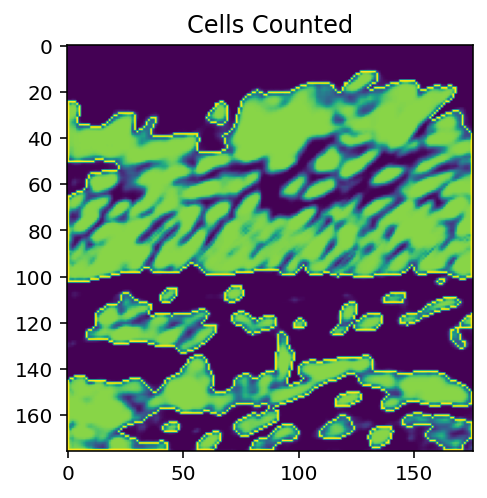

Found 20 cells.
	Size of cell 0: 11
	Size of cell 1: 21
	Size of cell 2: 23
	Size of cell 3: 10
	Size of cell 4: 22
	Size of cell 5: 35
	Size of cell 6: 13
	Size of cell 7: 247
	Size of cell 8: 7
	Size of cell 9: 21
	Size of cell 10: 28
	Size of cell 11: 30
	Size of cell 12: 33
	Size of cell 13: 9
	Size of cell 14: 61
	Size of cell 15: 7
	Size of cell 16: 12
	Size of cell 17: 6
	Size of cell 18: 14
	Size of cell 19: 222


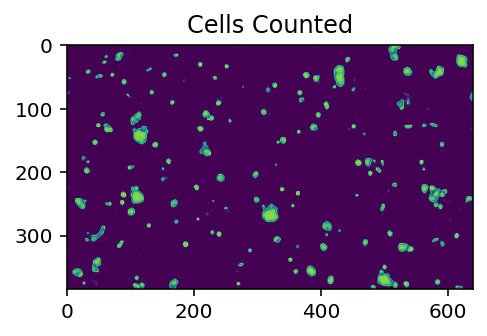

Found 143 cells.
	Size of cell 0: 8
	Size of cell 1: 10
	Size of cell 2: 21
	Size of cell 3: 6
	Size of cell 4: 8
	Size of cell 5: 8
	Size of cell 6: 12
	Size of cell 7: 24
	Size of cell 8: 14
	Size of cell 9: 8
	Size of cell 10: 41
	Size of cell 11: 10
	Size of cell 12: 25
	Size of cell 13: 24
	Size of cell 14: 11
	Size of cell 15: 7
	Size of cell 16: 8
	Size of cell 17: 23
	Size of cell 18: 9
	Size of cell 19: 6
	Size of cell 20: 28
	Size of cell 21: 19
	Size of cell 22: 13
	Size of cell 23: 8
	Size of cell 24: 14
	Size of cell 25: 11
	Size of cell 26: 12
	Size of cell 27: 8
	Size of cell 28: 15
	Size of cell 29: 5
	Size of cell 30: 10
	Size of cell 31: 4
	Size of cell 32: 15
	Size of cell 33: 12
	Size of cell 34: 10
	Size of cell 35: 6
	Size of cell 36: 30
	Size of cell 37: 8
	Size of cell 38: 22
	Size of cell 39: 9
	Size of cell 40: 8
	Size of cell 41: 16
	Size of cell 42: 6
	Size of cell 43: 16
	Size of cell 44: 6
	Size of cell 45: 36
	Size of cell 46: 11
	Size of cell 47: 4
	Size

In [23]:
import cv2
count_cells(img_1)
count_cells(img_secbis)
count_cells(img_2)

As you can see the function performs quite well on the first image but not as well on the second.
Indeed in the second image, cells are more numerous, densely aggregated more aggregated and sometimes they seem to merge which makes the segmentation harder.
 
 In the second and third part, we will thus try to improve the results on the second image he(1).png.


# **II Post Processing with thresholding, erosion and dilation**

Consequently, we will try to further post process the results with different filters and various thresholding techniques in order to see if we can obtain better results.

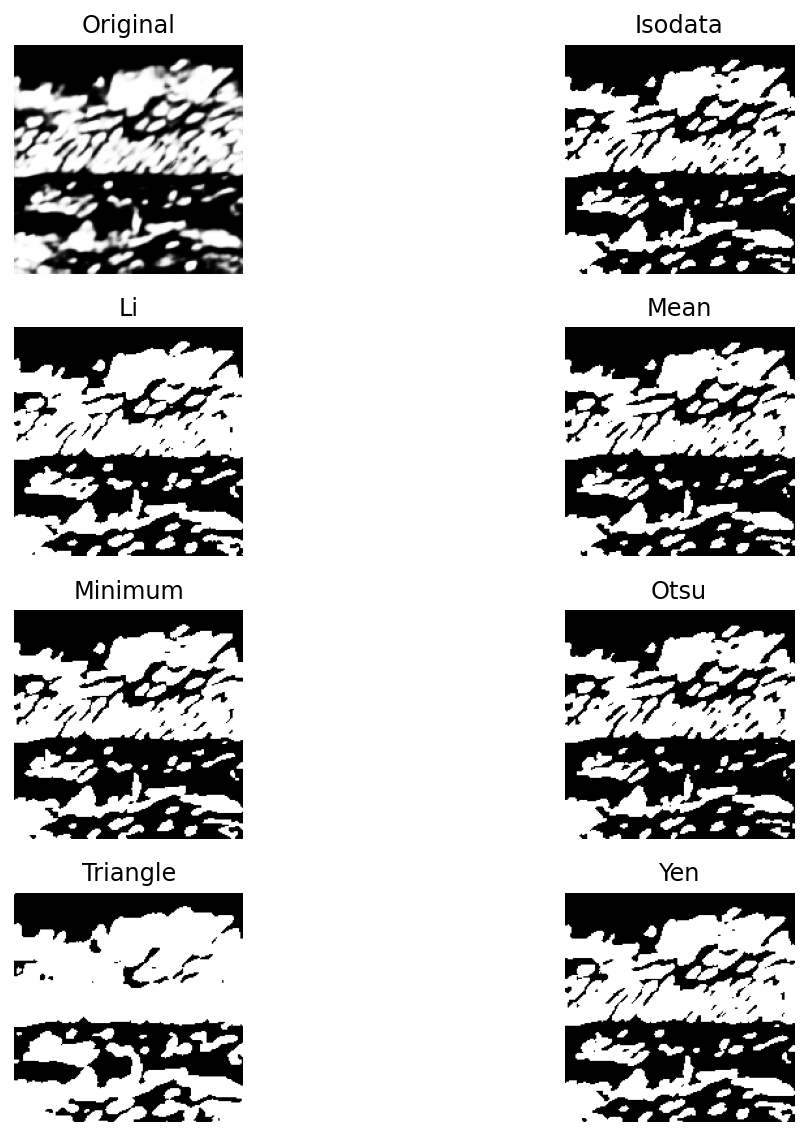

In [9]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(img_secbis, figsize=(10, 8), verbose=False)
plt.show()

A little bit better but not sufficient for good segmentation yet. Let see how we can modify the threshold to further improve binarization.

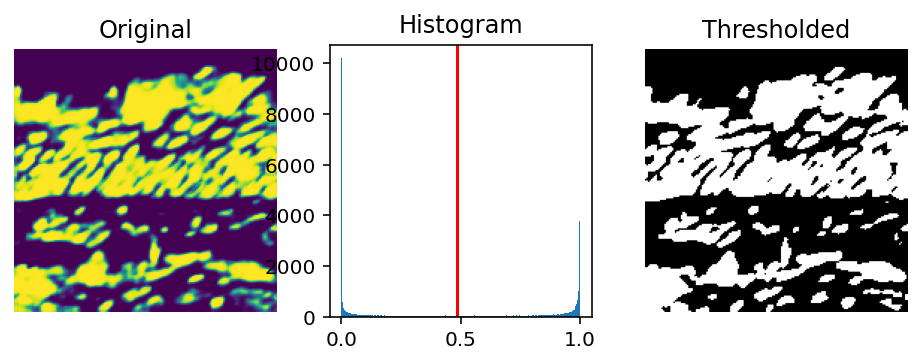

In [10]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu

thresh = threshold_otsu(img_secbis)
binary = img_secbis > thresh
binary = np.multiply(binary, 1) 
binary_ = binary.astype('float')
#binary_ = (binary_ + 0.5) / 9
fig, axes_ = plt.subplots(ncols=3, figsize=(8, 2.5))
ax_ = axes_.ravel()

ax_[0] = plt.subplot(1, 3, 1)
ax_[1] = plt.subplot(1, 3, 2)
ax_[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax_[0].imshow(img_secbis)
ax_[0].set_title('Original')
ax_[0].axis('off')

ax_[1].hist(img_secbis.ravel(), bins=256)
ax_[1].set_title('Histogram')
ax_[1].axvline(thresh, color='r')

ax_[2].imshow(binary_, cmap=plt.cm.gray)
ax_[2].set_title('Thresholded')
ax_[2].axis('off')

plt.show()

Interestingly we can see that most of the values are located at the extreme of the grey levels, so establishing a threshold around 0.8-0.98 could help to denoise and separate the areas.

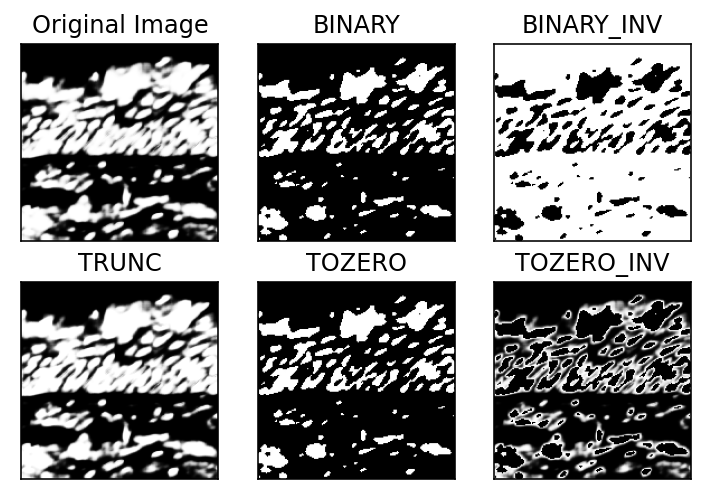

In [11]:
def test_all_thresh(img, thresh):

  ret,thresh1 = cv2.threshold(img,thresh,255,cv2.THRESH_BINARY)
  ret,thresh2 = cv2.threshold(img,thresh,255,cv2.THRESH_BINARY_INV)
  ret,thresh3 = cv2.threshold(img,thresh,255,cv2.THRESH_TRUNC)
  ret,thresh4 = cv2.threshold(img,thresh,255,cv2.THRESH_TOZERO)
  ret,thresh5 = cv2.threshold(img,thresh,255,cv2.THRESH_TOZERO_INV)

  titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
  images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

  for i in np.arange(6):
      plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
      plt.title(titles[i])
      plt.xticks([]),plt.yticks([])

  plt.show()

test_all_thresh(img_secbis, 0.98)

So binary inverse look promising. Let's make some erosion on the result to better dissociate some cells from each others. In order to do so we refacture the original count_cells function by incorporating erosion and dilatation functions.

In [12]:
def count_cells_vanilla(pred_mask, t=0.98):
    
    img_mask=np.squeeze(pred_mask)
    plt.imsave('test_1.png', img_mask)

    image = Image.open('test_1.png').convert("L")
    #image = cv2.cvtColor(np.float32(image), cv2.COLOR_RGB2GRAY)
    img = np.asarray(image)
    img = img.copy()
    #blur = cv2.GaussianBlur(img, (3, 3), 0)
    (t, binary) = cv2.threshold(img, t, 255, cv2.THRESH_BINARY_INV)

    # find contours
    binary.astype('int32')
    elements = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    binary = cv2.dilate(binary,elements,iterations=3)
    #binary = cv2.erode(binary, elements, iterations =2)
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # create all-black mask image
    mask = np.zeros(img.shape, dtype="uint8")

    # draw white rectangles for each object's bounding box
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 255, 255), -1)

    # draw contours over original image
    cv2.drawContours(img, contours, -1, (255, 100, 100), 1)

    fig1 = plt.figure(figsize=(8, 8))
    plt.subplot(121).set_title('Cells Counted after dilation')
    plt.imshow(img)
    plt.show()

    # print table of contours and sizes
    print("Found %d cells." % len(contours))
    for (i, c) in enumerate(contours):
        print("\tSize of cell %d: %d" % (i, len(c)))
    return

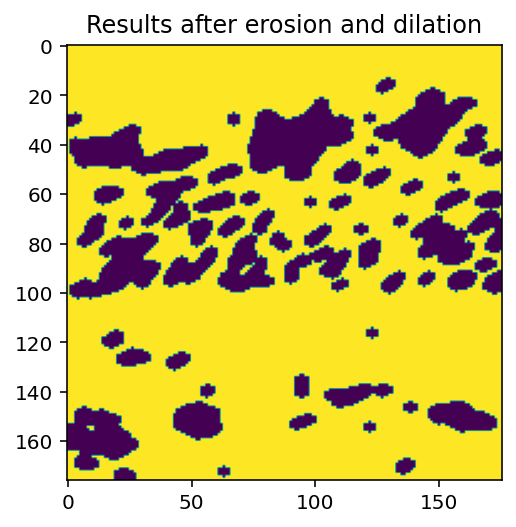

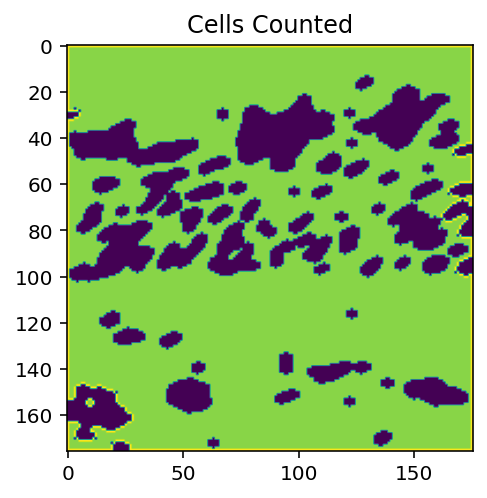

Found 2 cells.
	Size of cell 0: 8
	Size of cell 1: 143


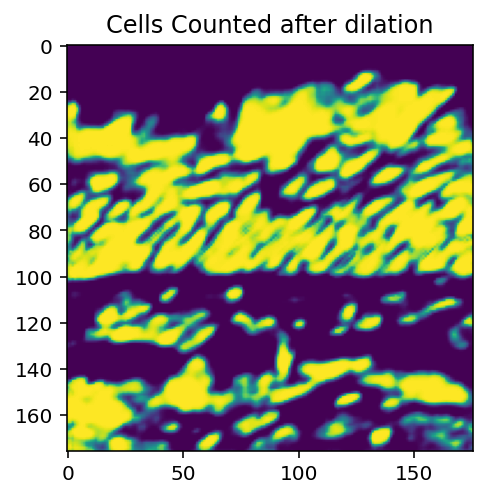

Found 0 cells.


In [13]:
ret,thresh1 = cv2.threshold(img_secbis,0.98,255,cv2.THRESH_BINARY_INV)
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(thresh1,cv2.MORPH_OPEN,kernel, iterations = 2)
erode = cv2.erode(thresh1, kernel, iterations=1)
elements = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
dilation = cv2.dilate(thresh1,kernel,iterations =2)
eroded = cv2.erode(dilation, elements, iterations =1)
plt.imshow(eroded)
plt.title('Results after erosion and dilation')
plt.show()
#count_cells_vanilla(dilation)
count_cells(eroded)
count_cells_vanilla(img_secbis, t=0.98)

Disapointingly, does not work as expected while we have cleary denoised the image and separate different cells from each other though imperfectly. 

# III. Post Processing by adding Blob Detectors and Active Contours to the previous algorithms

Other methods such as active and morphological contours as well as blob counting with Laplacian of Gaussian, difference of Gaussian and determinant of Gaussian could be used and should display better results.

Lets try active contour and blob detector !

In [14]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

def blob_detect(image):

  plt.imsave('blob.png', image)
  #image = Image.open('.png').convert("L")
  image = cv2.imread('blob.png')
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  blobs_log = blob_log(image_gray, max_sigma=60, num_sigma=10, threshold=.1)
  # Compute radii in the 3rd column.
  blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

  blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
  blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

  blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

  blobs_list = [blobs_log, blobs_dog, blobs_doh]
  colors = ['yellow', 'lime', 'red']
  titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
            'Determinant of Hessian']
  sequence = zip(blobs_list, colors, titles)
  print('')
  print('')
  print('--------------------- Blob Detection Algorithms ---------------------')
  fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
  ax = axes.ravel()

  for idx, (blobs, color, title) in enumerate(sequence):
      ax[idx].set_title(title)
      ax[idx].imshow(image)
      for blob in blobs:
          y, x, r = blob
          c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
          ax[idx].add_patch(c)
      ax[idx].set_axis_off()

  plt.tight_layout()
  plt.show()
  print("number of cells detected", blobs_doh.shape[0])

def morpho_snake(img):

    import numpy as np
    import matplotlib.pyplot as plt
    from skimage import data, img_as_float
    from skimage.segmentation import (morphological_chan_vese,
                                      morphological_geodesic_active_contour,
                                      inverse_gaussian_gradient,
                                      checkerboard_level_set)

    
    def store_evolution_in(lst):
        """Returns a callback function to store the evolution of the level sets in
        the given list.
        """

        def _store(x):
            lst.append(np.copy(x))

        return _store

    # Morphological ACWE
    plt.imsave('snake.png', img)
    #image = Image.open('.png').convert("L")
    img = cv2.imread('snake.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #image = cv2.cvtColor(np.float32(image), cv2.COLOR_RGB2GRAY)
    # Initial level set
    init_ls = checkerboard_level_set(img.shape, 6)
    # List with intermediate results for plotting the evolution
    evolution = []
    callback = store_evolution_in(evolution)
    ls = morphological_chan_vese(img, 35, init_level_set=init_ls, smoothing=3,
                                 iter_callback=callback)

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    ax = axes.flatten()

    ax[0].imshow(img, cmap="gray")
    ax[0].set_axis_off()
    ax[0].contour(ls, [0.5], colors='r')
    ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

    ax[1].imshow(ls, cmap="gray")
    ax[1].set_axis_off()
    contour = ax[1].contour(evolution[2], [0.5], colors='g')
    contour.collections[0].set_label("Iteration 2")
    contour = ax[1].contour(evolution[7], [0.5], colors='y')
    contour.collections[0].set_label("Iteration 7")
    contour = ax[1].contour(evolution[-1], [0.5], colors='r')
    contour.collections[0].set_label("Iteration 35")
    ax[1].legend(loc="upper right")
    title = "Morphological ACWE evolution"
    ax[1].set_title(title, fontsize=12)

    # Morphological GAC
    #image = img_as_float(data.coins())
    gimage = inverse_gaussian_gradient(img)

    # Initial level set
    init_ls = np.zeros(img.shape, dtype=np.int8)
    init_ls[10:-10, 10:-10] = 1
    # List with intermediate results for plotting the evolution
    evolution = []
    callback = store_evolution_in(evolution)
    ls = morphological_geodesic_active_contour(gimage, 230, init_ls,
                                               smoothing=1, balloon=-1,
                                               threshold=0.69,
                                               iter_callback=callback)

    ax[2].imshow(img, cmap="gray")
    ax[2].set_axis_off()
    ax[2].contour(ls, [0.5], colors='r')
    ax[2].set_title("Morphological GAC segmentation", fontsize=12)

    ax[3].imshow(ls, cmap="gray")
    ax[3].set_axis_off()
    contour = ax[3].contour(evolution[0], [0.5], colors='g')
    contour.collections[0].set_label("Iteration 0")
    contour = ax[3].contour(evolution[100], [0.5], colors='y')
    contour.collections[0].set_label("Iteration 100")
    contour = ax[3].contour(evolution[-1], [0.5], colors='r')
    contour.collections[0].set_label("Iteration 230")
    ax[3].legend(loc="upper right")
    title = "Morphological GAC evolution"
    ax[3].set_title(title, fontsize=12)

    fig.tight_layout()
    plt.show()
    print(evolution[7].shape)

/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma 



--------------------- Blob Detection Algorithms ---------------------


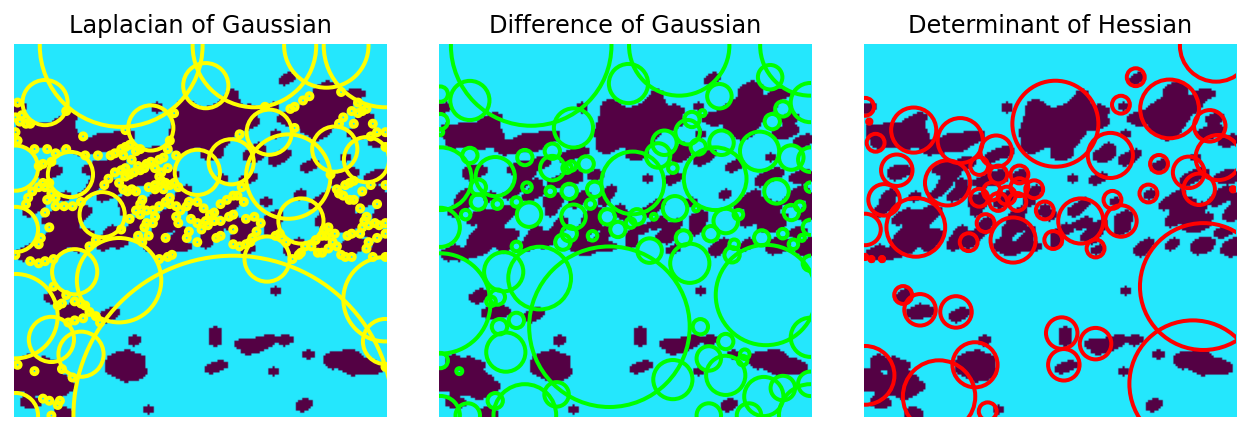

number of cells detected 58


--------------------- Active Contours Algorithms --------------------


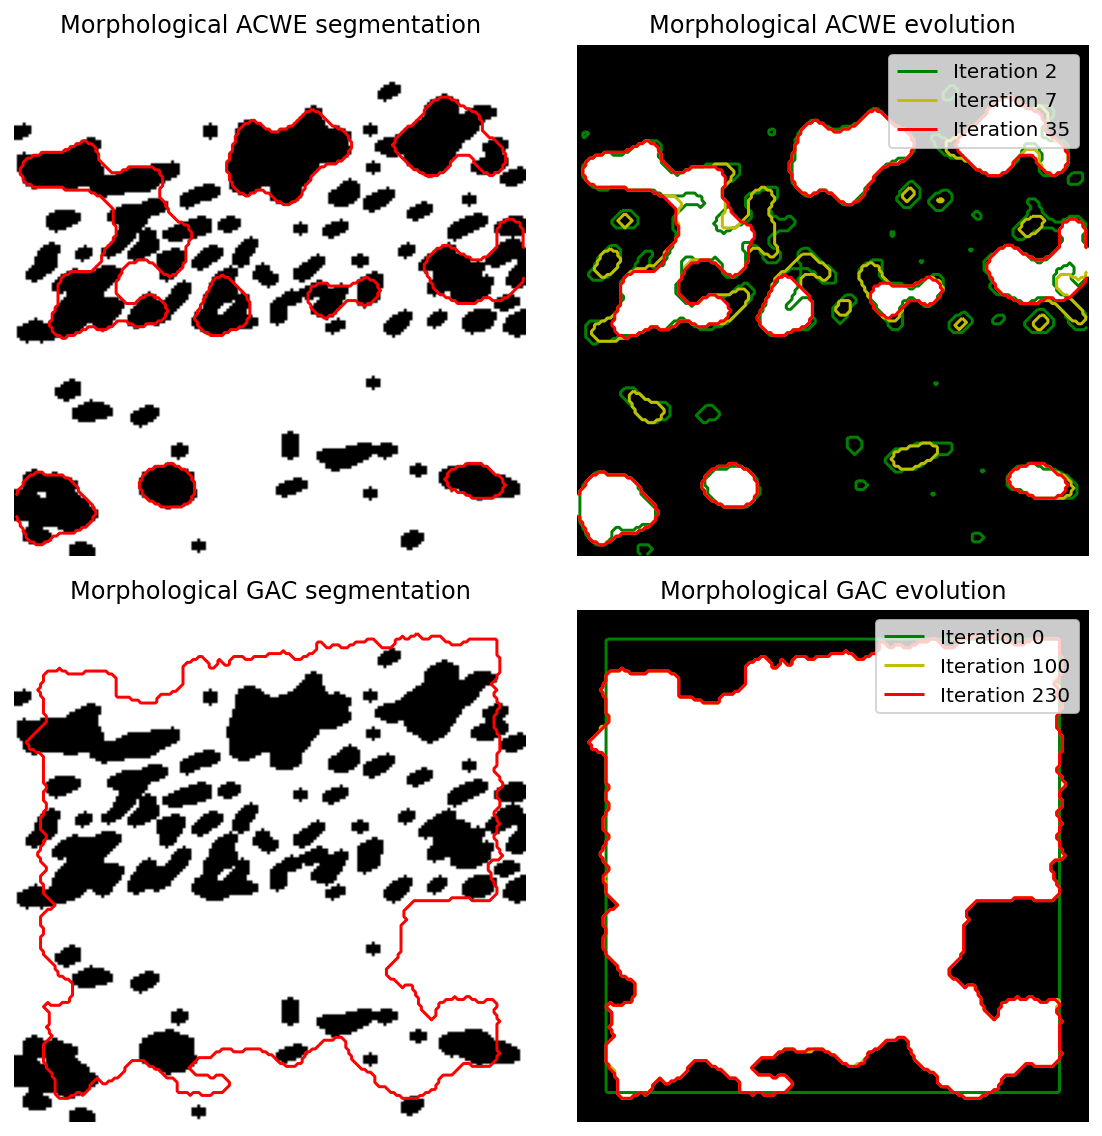

(176, 176)


In [15]:
blob_detect(eroded)
print('')
print('')
print('--------------------- Active Contours Algorithms --------------------')
morpho_snake(eroded)

Not bad with determinant of Hessian, though it could be finetuned and big blobs constituted of multiple cells are still present and create a strong bias. 
Fine tuning of the parameters should be done in order to further improve the results.

Morphological Snakes of the type ACWE works best at the second iteration but they are less performant than determinant of Hessian.



# **IV Conclusion**



We haven't use adaptive thresholding methods like Savola, Niblack and Wolf threshold wich could help to separate the different cells from each other

Additionnaly, we think that a segmentation with fuzzy-cmeans algorithm could really easily discriminate and isolate the blue cells from each others. 

Finally, other algorithms such as morphological contours like snakes/active contours and watershed algorithms might be considered, tested and benchmark to compare the results to what we have done. 

To conclude, one may refer to the recent work on nuclei segmentation by L. Putzu et Fumera (2020) with different CNN based methods [1] as well as the following study by Le Hou et al [2] based on datasets comprised of roughly 5 billion quality controlled nucleis from more than 5,060 TCGA WSIs from 10 different TCGA cancer types and 1,356 manually segmented TCGA image patches from the same 10 cancer types plus additional 4 cancer types. 

In addition, one may check the work done in the context of the 2020 Multi-Organ Nuclei Segmentation and Classification Challenge (MonuSac 2020) [3] as well as the paper summing up the results of the 2018 Data Science Bowl which was on Nucleus segmentation across imaging experiments [4]. Open source githubs from top challengers of this competition are available and listes under the [4] references.



# **V References**

[1] Lorenzo Putzu and Giorgio Fumera (2020) *An Empirical Evaluation of Nuclei Segmentationfrom H&E Images in a Real Application Scenario*, Applied Sciences MDPI. 

[2] Le Hou et al (2020) *Dataset of segmented nuclei in hematoxylin and eosin stained histopathology images of ten cancer types*, Nature. 
Code available on github.

[3] https://monusac-2020.grand-challenge.org/ 

[4] Juan. C. Ceicedo et al (2019) *Nucleus segmentation across imaging experiments: the 2018 Data Science Bowl*, Nature methods.

1st Prize :  https://github.com/selimsef/dsb2018_topcoders

2nd Prize :  https://github.com/jacobkie/2018DSB 

3rd Prize :  https://github.com/Lopezurrutia/DSB_2018 